# Time Series - Part-2

We will cover the following in this Part-2

- How to Measure Forecast
- Move, smoothe, evaluate
    - Rolling window estimations
    - Exponential smoothing, Holt-Winters model
    - Time-series cross validation
    - parameter selection
- Econometric approach
    - Stationarity, unit root
    - Getting rid of non-stationarity
    - SARIMA model building

Importing required libraries. 

We will use *`statsmodels`* library containing very useful *`statistical`* modeling functions, including ***Time Series***. 

In [35]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more beautiful plots
%matplotlib inline

In [36]:
# Set sns to show some standard charectaristics throughout the notebook

sns.set(context='talk', style='darkgrid', palette='deep', 
        font='sans-serif', font_scale=1.2, color_codes=False,
        rc={"lines.linewidth": 2})

#sns.set_context("paper")
#sns.set_context("talk")
#sns.set_context("poster")
#sns.set_context("notebook")

In [37]:
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

In [38]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [39]:
from itertools import product                 # some useful functions like cartesian product
from tqdm import tqdm_notebook

import warnings                               # `do not disturbe` mode
warnings.filterwarnings('ignore')

#### Familiarising with the data

In [40]:
df = pd.read_csv('international-airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Let us change the `Month` column to real datetime values suitable for ***Time Series*** data 

In [41]:
df.Month = pd.to_datetime(df.Month)
df.set_index('Month', inplace=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


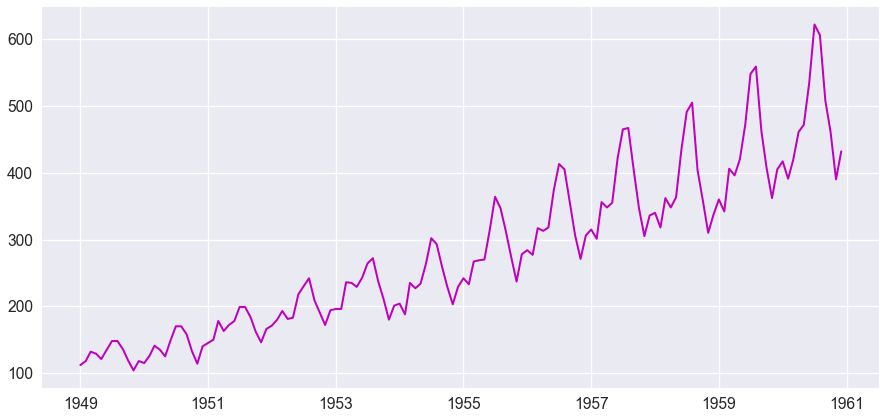

In [42]:
plt.figure(figsize=(15, 7))
plt.plot(df.Passengers, 'm')
plt.show()

## How to measure forecast - quality metrics

- ***Mean Absolute Error***: It has the same unit of measurement as the initial series, [0, +inf)
*`sklearn.metrics.mean_absolute_error`*

- ***Mean Squared Error***: Commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf)
*`sklearn.metrics.mean_squared_error`*

- ***Mean Squared Logarithmic Error***: Same as MSE but takes logarithm of the series. This allows to pay attention to even small mistakes, usually is used when data has exponential trends, [0, +inf)
*`sklearn.metrics.mean_squared_log_error`*

- ***Mean Absolute Percentage Error***: Same as MAE but percentage - [0, +inf)
    - very convenient to assess the quality of the model 
    - Good for an `Apple-toApple` comparison
    - not implemented in sklearn

In [43]:
# Importing everything from above

from sklearn.metrics import mean_absolute_error, \
                            mean_squared_error,  \
                            mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Move 
Future value of the variable depends on the average ***n*** of its previous values and therefore we’ll use ***moving average***.

In [44]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df, 12) # prediction for the last observed day (past 24 hours)

476.1666666666667

***`Moving average`*** has another use case — smoothing of the original time series to indicate trends. Pandas has an implementation available `DataFrame.rolling(window).mean()`. The wider the window - the smoother will be the trend.

In [45]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,7))
    plt.title("Moving average - window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

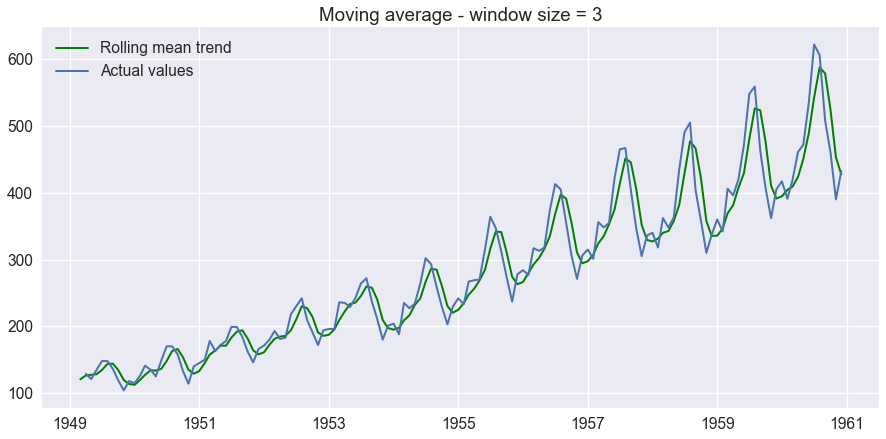

In [46]:
plotMovingAverage(df, 3)

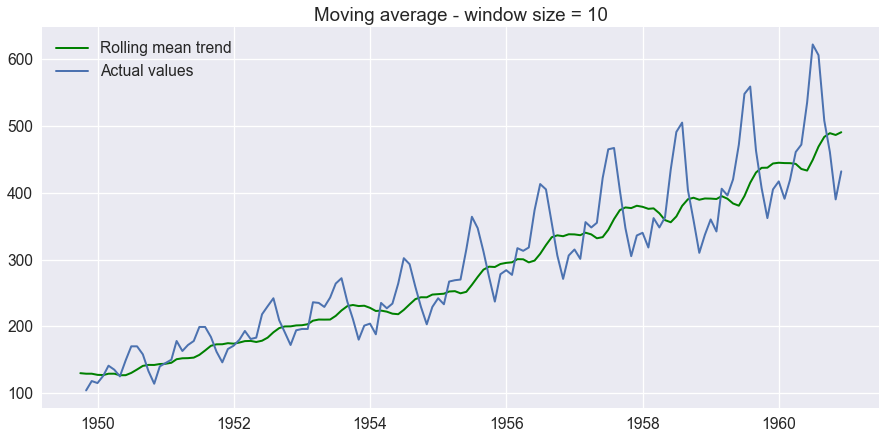

In [47]:
# A higher window size will flatten the sharp edges
plotMovingAverage(df, 10)

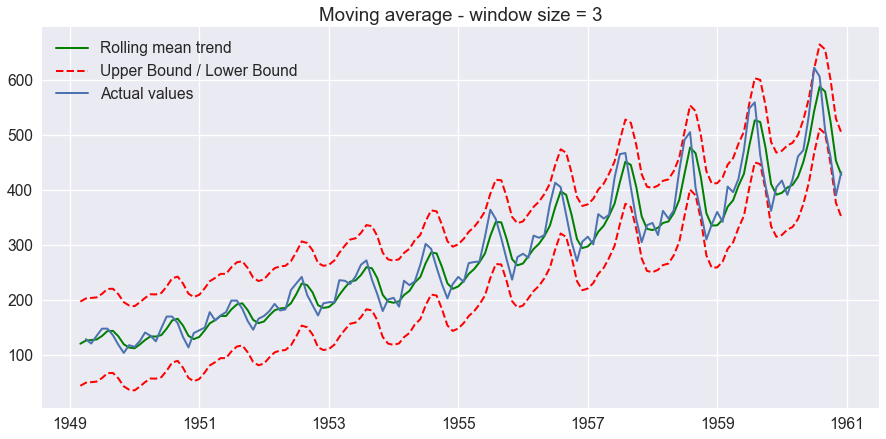

In [48]:
# Plot confidence intervals for our smoothed values
plotMovingAverage(df, 3, plot_intervals=True)

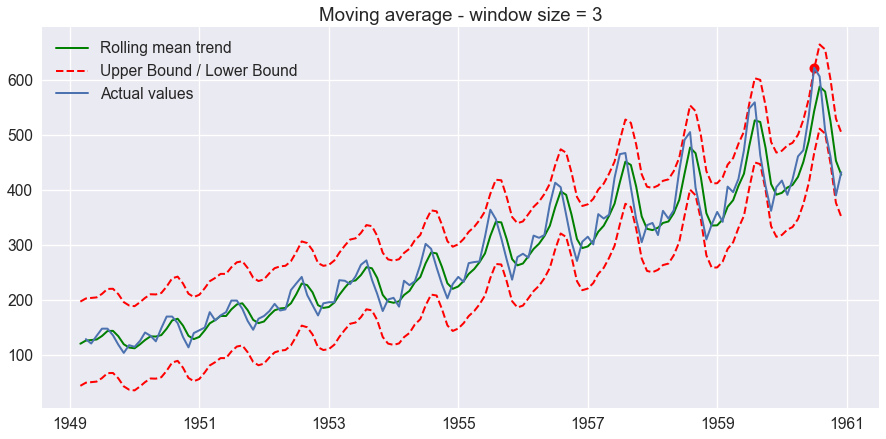

In [49]:
plotMovingAverage(df, 3, plot_intervals=True, plot_anomalies=True)

During the beginning of year 1961, there was a spike in the number of passengers that it crossed the upper bound.

This is the diadvantage of the simple `Moving Average`. Exponential Smoothing promises the best smoothing especially for time series data. We can use Single, Double and Triple Exponentials here. Let's jump directly into `Triple Exponential` 

### Triple Exponential Smoothing (Holt-Winters)

This method uses seasonality. This means we should’t use the method if our time series do not have seasonality, which is not the case in our example. Seasonal component in the model will explain repeated variations around intercept and trend, and it will be described by the length of the season, in other words by the period after which variations repeat. For each observation in the season there’s a separate component, for example, if the length of the season is 7 (weekly seasonality), we will have 7 seasonal components, one for each day of the week.

Here `Intercept` depends on the current value of the series minus corresponding seasonal component leaving the trend unchanged.

The component is smoothed through all the available seasons, for example, if we have a Monday component then it will only be averaged with other Mondays. 


**Holt-Winters** known by the last names of its creators — ***Charles Holt*** and his student ***Peter Winters***. 

In [50]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBound.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBound.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBound.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBound.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])


## Time series cross validation

**How to estimate model parameters automatically**

As usual, we have to choose a loss function suitable for the task, that will tell us how close the model approximates data. 

Then using cross-validation we will evaluate our chosen loss function for given model parameters, calculate gradient, adjust model parameters and so forth, bravely descending to the global minimum of error.

**How to do cross-validation on time series**

Because, time series do have ***time structure*** and one just can’t randomly mix values in a fold without preserving this structure, otherwise all time dependencies between observations will be lost.

***The answer is***: First train the model on a small segment of the time series, from the beginning until some ***t***, make predictions for the next ***t+n*** steps and calculate an error. 

Then expand the training sample to ***t+n*** value and make predictions from ***t+n*** until ***t+(2∗n)***, and we continue moving our test segment of the time series until we hit the last available observation. 

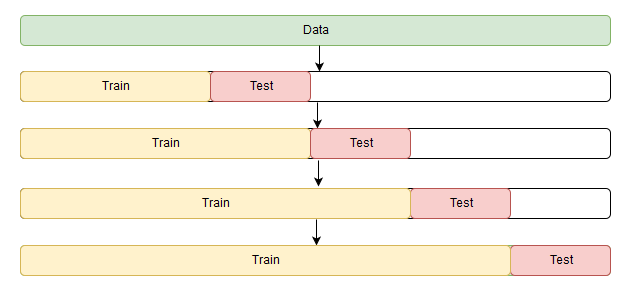

Finding optimal parameters for the Holt-Winters model.<br>
Remember that data has monthly seasonality, hence the *`slen=12`* parameter. 

Sklearn has *`TimeSeriesSplit`* which does the cros validation in a neat way

In [51]:
from sklearn.model_selection import TimeSeriesSplit 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=12):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In all models of exponential smoothing, there is a constraint on how big smoothing parameters could be, each of them is in the range from 0 to 1, therefore to minimize loss function we have to choose an algorithm that supports constraints on model parameters, in our case — `Truncated Newton conjugate gradient` (TNC).

In [52]:
%%time
data = df.Passengers[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 36 months
model = HoltWinters(data, slen = 12, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 36, scaling_factor = 3)
model.triple_exponential_smoothing()

0.02183727488049131 0.17814383464485206 0.5086156204641146
CPU times: user 2.49 s, sys: 14.1 ms, total: 2.51 s
Wall time: 2.48 s


Plotting Holt-Winters 

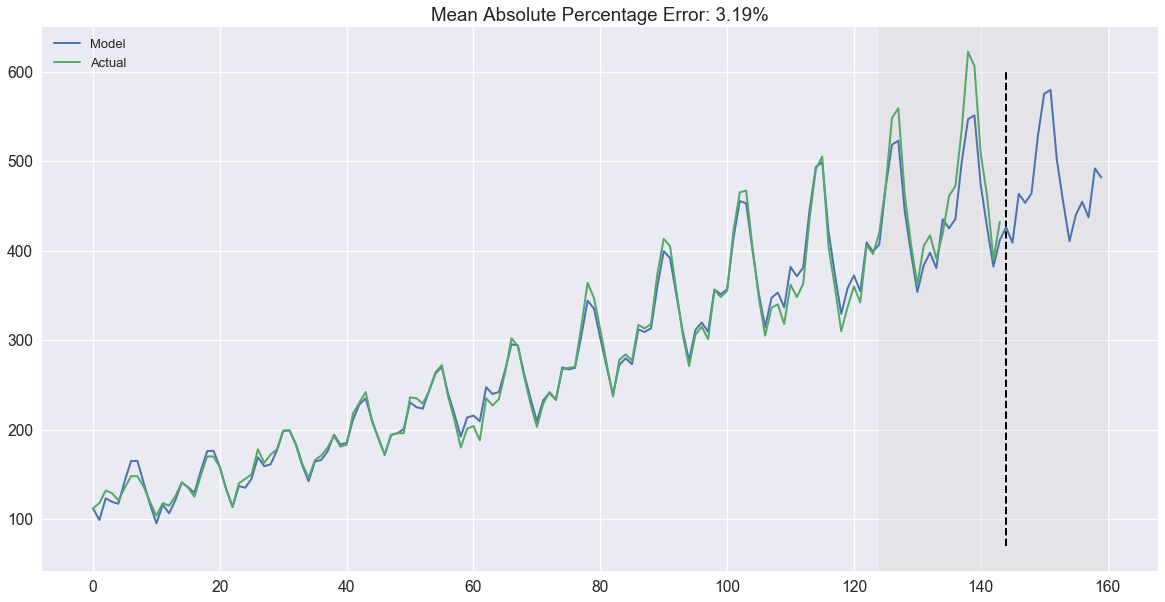

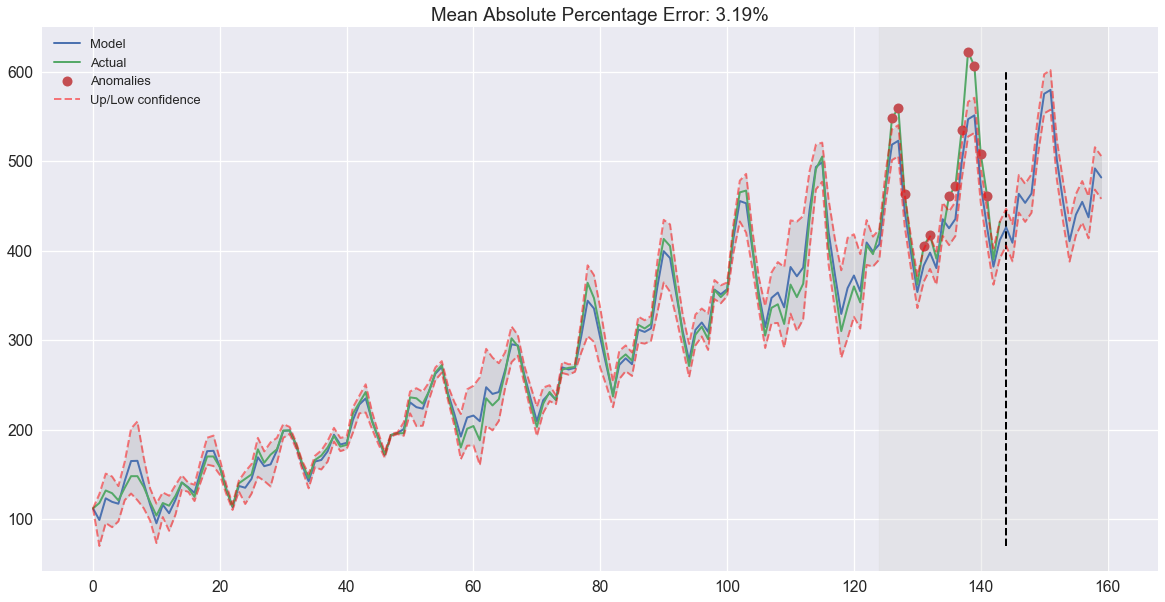

In [53]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBound[:len(series)]] = \
            series.values[series.values<model.LowerBound[:len(series)]]
        anomalies[series.values>model.UpperBound[:len(series)]] = \
            series.values[series.values>model.UpperBound[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBound, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBound, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBound, 
                         y2=model.LowerBound, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBound), ymax=max(model.UpperBound), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
plotHoltWinters(df.Passengers)
plotHoltWinters(df.Passengers, plot_intervals=True, plot_anomalies=True)

It is clear that the model reacts quite sharply to the changes in the structure of the series but then quickly returns deviation to the normal values, `forgetting` the past. This feature of the model allows us to quickly build anomaly detection systems even for quite noisy series

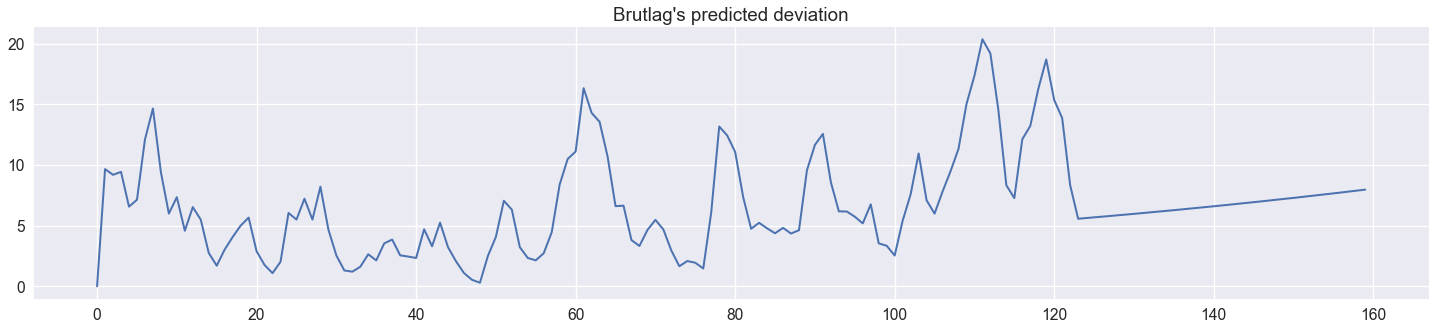

In [54]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## Econometric approach
### Stationarity

An important property of time series data is *`stationary`* - which means it doesn’t change its statistical properties over time, namely mean and variance do not change over time.<br>

Most of the time series models predict those properties (mean or variance, for example), and that’s why predictions would be wrong if the original series were not stationary. Unfortunately most of the time series we get in real life are non-stationary.



### Getting rid of non-stationarity and building SARIMA

First, let us make the series stationary through a step by step process.


In [55]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    style = 'fivethirtyeight'
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


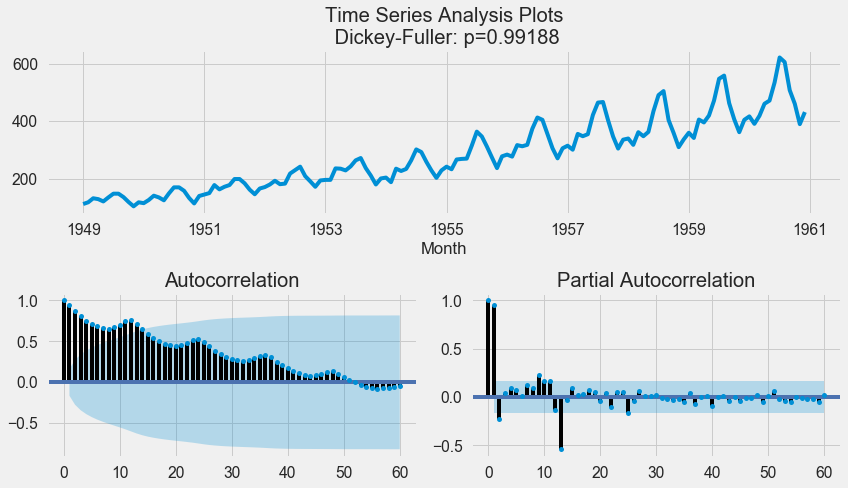

In [56]:
#df.head()
tsplot(df.Passengers, lags=60)

#### Getting rid of seasonality

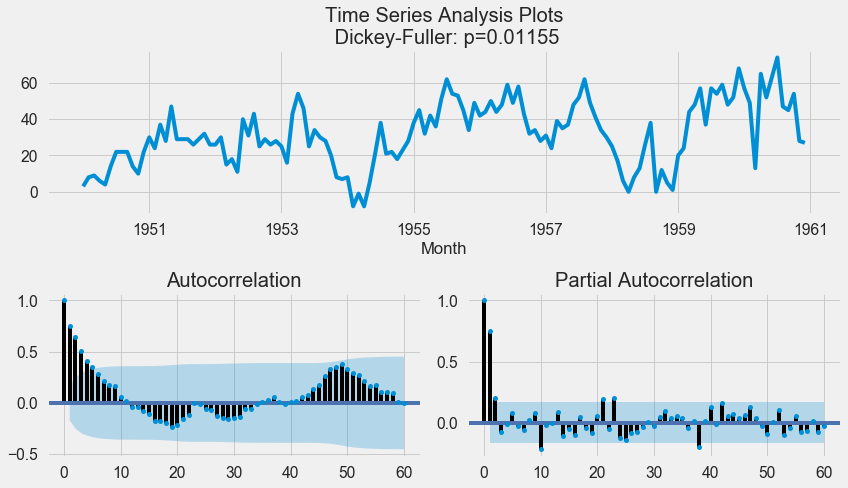

In [57]:
df_diff = df.Passengers - df.Passengers.shift(12)
tsplot(df_diff[12:], lags=60)

Autocorrelation function still has too many significant lags. To remove them we’ll take first differences — subtraction of series from itself with lag 1

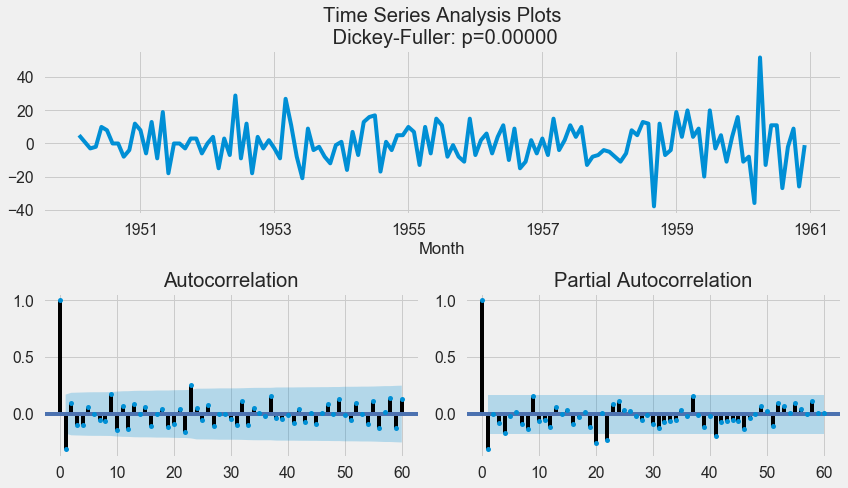

In [58]:
df_diff = df_diff - df_diff.shift(1)
tsplot(df_diff[12+1:], lags=60)

Series now look perfect, oscillating around zero, Dickey-Fuller indicates that it’s stationary and the number of significant peaks in ACF has dropped. 

Let us start modelling!

Let us test various models and see which one is better.

In [59]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 12 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [60]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df.Passengers, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [61]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

A Jupyter Widget


CPU times: user 1min 49s, sys: 3min 14s, total: 5min 3s
Wall time: 41.5 s


In [62]:
result_table.head()

,parameters,aic
0,"(3, 4, 1, 1)",1018.691181
1,"(3, 4, 0, 1)",1018.691181
2,"(2, 4, 0, 0)",1019.162591
3,"(2, 4, 1, 0)",1019.162591
4,"(2, 2, 0, 0)",1019.290208


In [63]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df.Passengers, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())


                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 4)x(1, 1, 1, 12)   Log Likelihood                -499.346
Date:                            Mon, 18 Jun 2018   AIC                           1018.691
Time:                                    12:08:55   BIC                           1048.389
Sample:                                01-01-1949   HQIC                          1030.759
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2506      0.177     -1.417      0.156      -0.597       0.096
ar.L2         -0.1309      0.149   

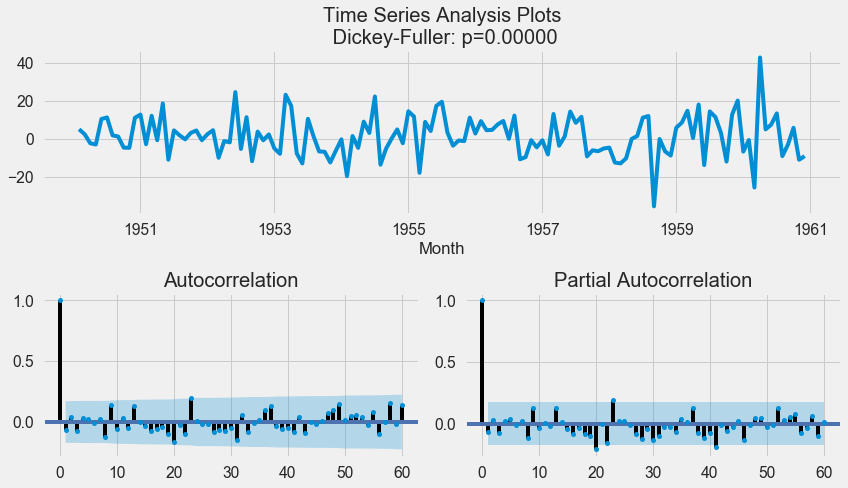

In [64]:
tsplot(best_model.resid[12+1:], lags=60)

Now the residuals are stationary, and there are no apparent autocorrelations. 

Let's make predictions using our model.

In [65]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

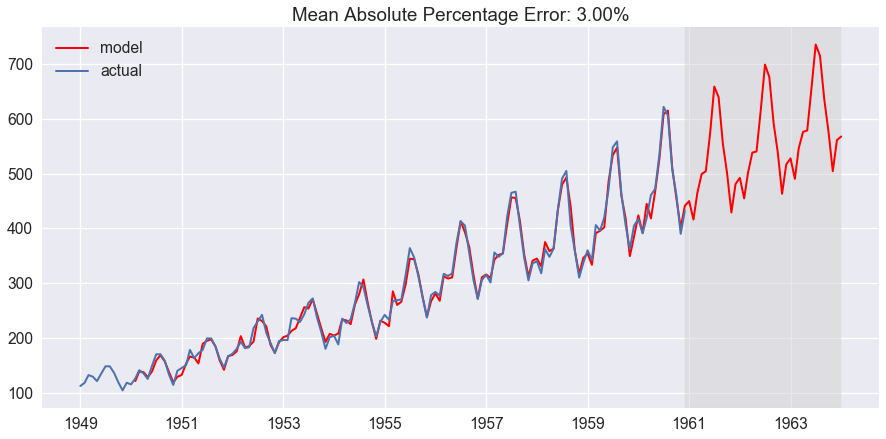

In [66]:
plotSARIMA(df, best_model, 36)

The model is wrong by 3.0% on average, which is an excellent result. However, the overall costs of preparing data, making the series stationary, and selecting parameters might not be worth this accuracy.

## Linear Regression

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [68]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

Prepare the data with Features and transformations.


In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [70]:
def prepareData(series, lag_start, lag_end, test_size):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    '''    
    # datetime features
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    '''   

    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [80]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bound / lower bound", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

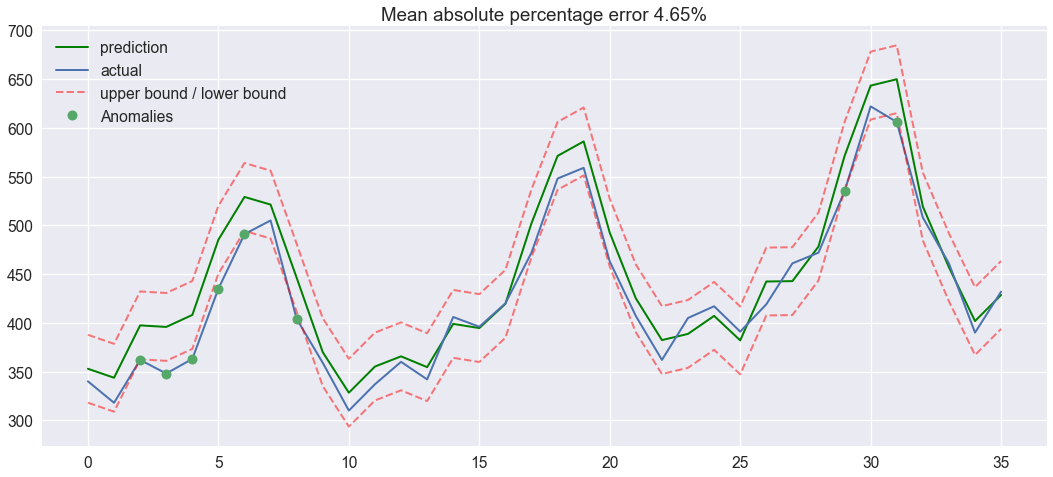

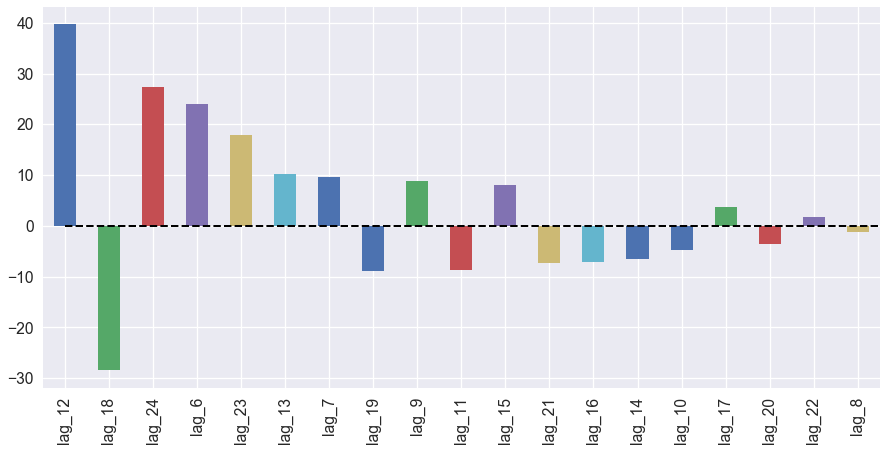

In [81]:
X_train, X_test, y_train, y_test =\
prepareData(df.Passengers, lag_start=6, lag_end=25, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
# plotCoefficients(lr)

#### Try Lasso & Ridge models

In [82]:
from sklearn.linear_model import LassoCV, RidgeCV


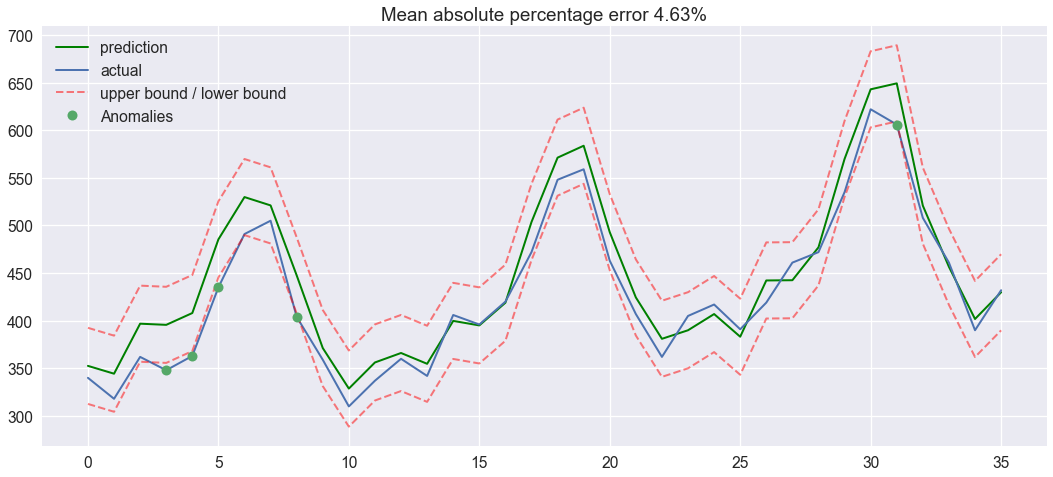

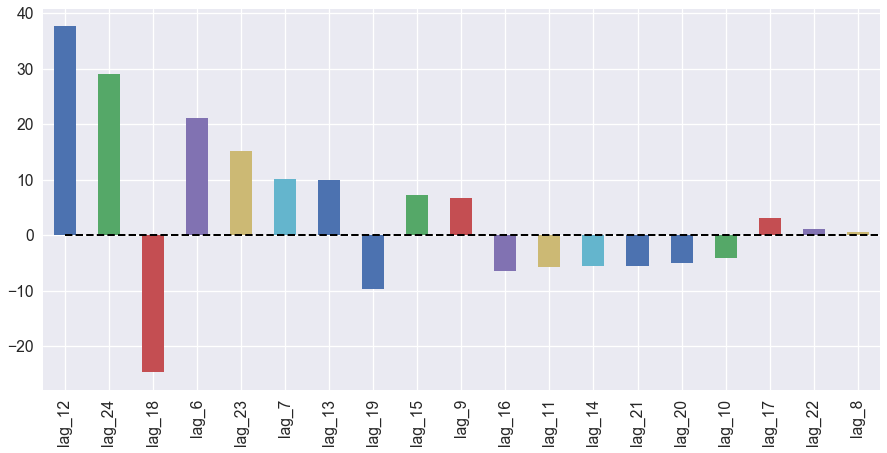

In [83]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
#plotCoefficients(ridge)

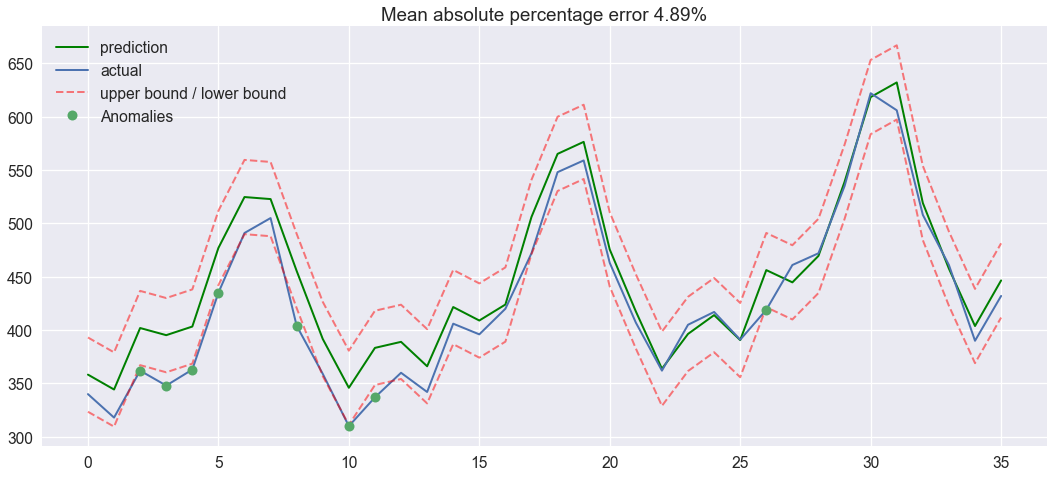

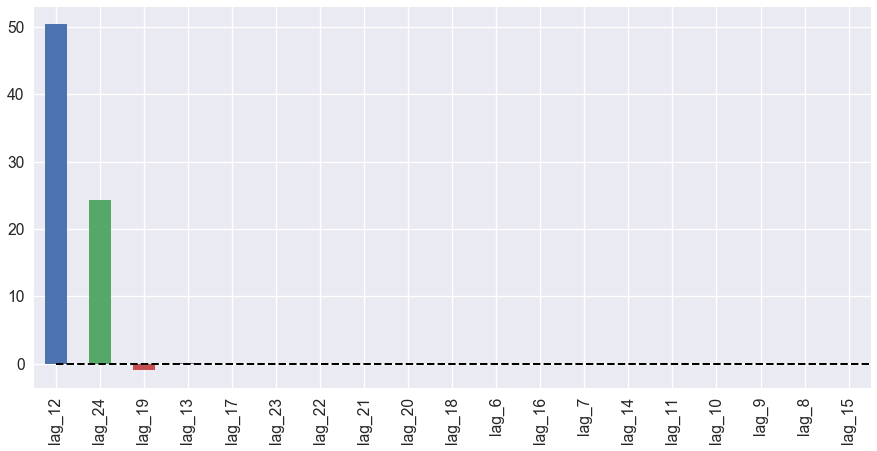

In [84]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
#plotCoefficients(lasso)

## Try XGBoost

In [85]:
import sys
from xgboost import XGBRegressor 

In [86]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

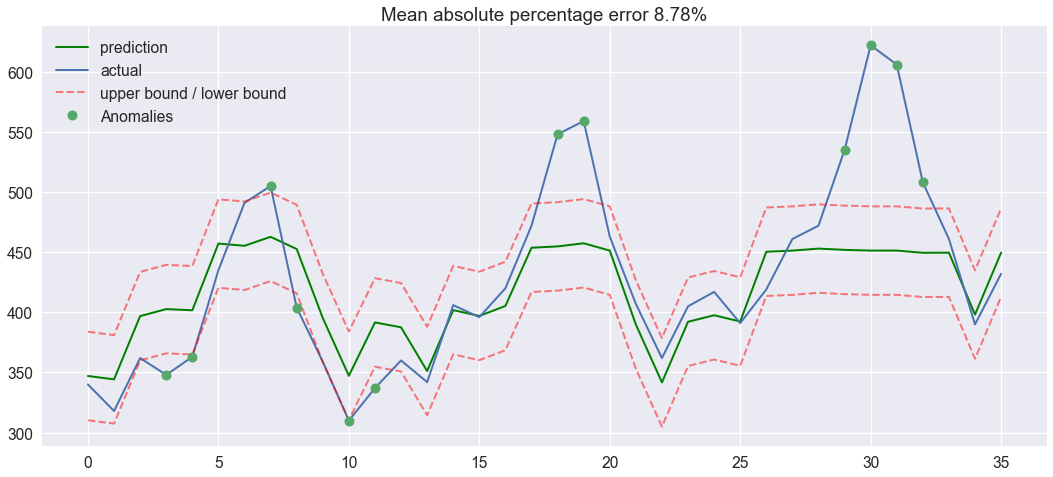

In [87]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)